# Image segmantation

#### F-CNN 
Fully Convolutional Neural Network (not `Fully Connected` Neural Network)

- `semantic segmentation` - all objects form single segment, each pixel associated to one segemnt
- `instance segmentation` - objects of the same type are treated as different object

---

### Image segmentation architecture

#### Encoder (feature extractor, dowsncsales image): 
- CNN with fully connected layers
- aggregates low level fearures to high level features (like eyes & ears)

#### Decoder (adds back the features lost in encoding, upscales image):
- replaces fully connected layers in a CNN
- up samples image to its original size to generate pixel mask
- FCN-32, FCN-16, FCN-8
- ---

#### SegNet

- architecture like Autoencoder,
- for every Pooling layer in encoder
- Upsampling layer in decoder

![alt text](segnet.png "Title")
---

---
### F-CNN architecture
- FCN-32 uses last layer from the encoder (enlarges it by 32 times after encoder shrinked it 32 times (each layer by 2x))
- FCN-16 uses 2 last layes from the encoder (takes output of last pool, upsamples it 2 times and combines with output of one before last pool layer. Then enlares the dimentionality by 16 times)
- FCN-8 like previous one uses three last layers outputs and enlarges the output by 8
![alt text](decoder.png "Title")
#### Upsampling (decoder upsamples image to its original size):
- reverse of pooling (instead of making pixel with the value being avg of 4 pixsels)
- uses a kernel like Convlution layer

#### Upsampling methods:
- `UpSampling2D` `x=UPSampling2D((2,2),'nearest'/'bilinear')`
- `Conv2DTranspose` (reverse of convolution using some kernel) `Conv2DTranspose(32,(3,3))`
---

#### data

In [25]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
#import h5py as h5py

In [ ]:
# !wget https://storage.googleapis.com/learning-datasets/fcnn-dataset.zip  -O /tmp/fcnn-dataset.zip

In [3]:
local_zip = './data/fcnn-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data/fcnn')
zip_ref.close()

In [2]:
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'byciclist', 'void']

In [3]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=224, width=224):
  img_raw = tf.io.read_file(t_filename)
  anno_raw = tf.io.read_file(a_filename)
  image = tf.image.decode_jpeg(img_raw)
  annotation = tf.image.decode_jpeg(anno_raw)

  image = tf.image.resize(image, (height, width,))
  annotation = tf.image.resize(annotation, (height, width,))
  image = tf.reshape(image, (height, width, 3,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  annotation = tf.reshape(annotation, (height, width, 1,))
  stack_list = []

  for c in range(len(class_names)):
    mask = tf.equal(annotation[:,:,0], tf.constant(c))
    stack_list.append(tf.cast(mask, dtype=tf.int32))

  annotation = tf.stack(stack_list, axis=2)

  image = image/127.5
  image -= 1

  return image, annotation

In [4]:
BATCH_SIZE = 64

def get_dataset_slice_paths(image_dir, label_map_dir):
  image_file_list = os.listdir(image_dir)
  label_map_file_list = os.listdir(label_map_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
  label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

  return image_paths, label_map_paths

def get_training_dataset(image_paths, label_map_paths):
  training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset

def get_validation_dataset(image_paths, label_map_paths):
  validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()

  return validation_dataset

In [5]:
training_image_paths, training_label_map_paths = get_dataset_slice_paths('./data/fcnn/dataset1/images_prepped_train/','./data/fcnn/dataset1/annotations_prepped_train/')
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths('./data/fcnn/dataset1/images_prepped_test/','./data/fcnn/dataset1/annotations_prepped_test/')

training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

In [6]:
training_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 12), dtype=tf.int32, name=None))>

#### VGG

In [7]:
def block(x,n_convs,filters,kernel,activation,pool_size,name):
    for i in range(n_convs):
        x=tf.keras.layers.Conv2D(filters,kernel,padding='same',name=f'{name}_conv{i+1}')(x)
    x=tf.keras.layers.MaxPooling2D(pool_size,name=f'{name}_pool{i+1}')(x)
    return x

In [8]:
#!wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg_weights_path = "./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [17]:
def VGG_16(image):
    x=block(image,2,64,(3,3),'relu',(2,2),'block1')
    p1=x
    x=block(x,2,128,(3,3),'relu',(2,2),'block2')
    p2=x
    x=block(x,3,256,(3,3),'relu',(2,2),'block3')
    p3=x
    x=block(x,3,512,(3,3),'relu',(2,2),'block4')
    p4=x
    x=block(x,3,512,(3,3),'relu',(2,2),'block5')
    p5=x
    vgg=tf.keras.models.Model(image,p5)
    vgg.load_weights(vgg_weights_path)
    n=4096
    c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
    c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)
    return (p1,p2,p3,p4,c7)

In [18]:
def fcn8_decoder(convs,classes):
    f1,f2,f3,f4,f5 = convs
    o1=tf.keras.layers.Conv2DTranspose(classes,(4,4),(2,2),use_bias=False)(f5)
    o1=tf.keras.layers.Cropping2D((1,1))(o1)
    o2=(f4)
    o2=tf.keras.layers.Cropping2D((1,1))(o2) # cropping removes excess pixels form borders
    o=tf.keras.layers.Add()([o1,o2])
    
    o=tf.keras.layers.Conv2DTranspose(classes,(4,4),(2,2))(o)
    o=tf.keras.layers.Cropping2D((1,1))(o1)
    o3=(f3)
    o3=tf.keras.layers.Cropping2D((1,1))(o3)
    o=tf.keras.layers.Add()([o,o3])

    o=tf.keras.layers.Conv2DTranspose(classes,(8,8),(8,8),use_bias=False)(o)
    o=tf.keras.layers.Activation('softmax')(o)
    return o

In [22]:
def segmentation_model():
    inputs=tf.keras.layers.Input(shape=(224,224,3))
    convs=VGG_16(inputs)
    outputs=fcn8_decoder(convs,12)
    model=tf.keras.models.Model(inputs=inputs,outputs=outputs)
    return model

In [23]:
model=segmentation_model()

ImportError: `load_weights` requires h5py package when loading weights from HDF5. Try installing h5py.

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=1E-2, momentum=0.9, nesterov=True),metrics=['accuracy'])

---

#### train

In [ ]:
train_count = 367
validation_count = 101

EPOCHS = 170

steps_per_epoch = train_count//BATCH_SIZE
validation_steps = validation_count//BATCH_SIZE

history = model.fit(training_dataset,steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

In [ ]:
results = model.predict(validation_dataset, steps=validation_steps)
results = np.argmax(results, axis=3)

---

## U-Net

U-Net is like F-CNN but with `skip-connections` in between.
![alt text](u-net.png "Title")

In [20]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
def encoder_block(x,filters,kernel=(3,3),pool_size=(2,2),dropout=0.3):
    n_convs=2
    f=x
    for i in range(n_convs):
        f=tf.keras.layers.Conv2D(filters,kernel,kernel_initializer = 'he_normal', padding = 'same')(f)
        f=tf.keras.layers.Activation('relu')(f)
    p=tf.keras.layers.MaxPooling2D(pool_size)(f)
    p=tf.keras.layers.Dropout(dropout)(p)
    return f,p # we return f to pass it in skip-connection

In [3]:
def encoder(input):
    f1,p1=encoder_block(input,64)
    f2,p2=encoder_block(p1,128)
    f3,p3=encoder_block(p2,256)
    f4,p4=encoder_block(p3,512)
    return p4, (f1,f2,f3,f4)

In [4]:
def bottleneck(input):
    n_convs=2
    filters=1024
    kernel=(3,3)
    x=input
    for i in range(n_convs):
        x=tf.keras.layers.Conv2D(filters,kernel,kernel_initializer = 'he_normal',padding = 'same')(x)
        x=tf.keras.layers.Activation('relu')(x)
    return x

In [5]:
def decoder_block(x,conv_output,filters,kernel=(3,3),strides=(2,2),dropout=0.3):
    u=tf.keras.layers.Conv2DTranspose(filters,kernel,strides,padding = 'same')(x)
    c=tf.keras.layers.concatenate([u,conv_output])
    c=tf.keras.layers.Dropout(dropout)(c)
    n_convs=2
    for i in range(n_convs):
        c=tf.keras.layers.Conv2D(filters,kernel,kernel_initializer = 'he_normal',padding = 'same')(c)
        c=tf.keras.layers.Activation('relu')(c)
    return c

In [6]:
def decoder(input,convs):
    f1,f2,f3,f4=convs
    c6=decoder_block(input,f4,512)
    c7=decoder_block(c6,f3,256)
    c8=decoder_block(c7,f2,128)
    c9=decoder_block(c8,f1,64)
    output=tf.keras.layers.Conv2D(3,(1,1),activation='softmax')(c9)
    return output

#### model

In [7]:
def unet():
    input=tf.keras.layers.Input(shape=(128,128,3))
    encoder_output,convs=encoder(input)
    bottle_neck=bottleneck(encoder_output)
    output=decoder(bottle_neck,convs)
    model=tf.keras.models.Model(inputs=input,outputs=output)
    return model

In [8]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#### data

In [10]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                                                         | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.08 url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|                                                                       | 0/19173078 [00:00<?, ? MiB/s]

Dl Size...: 100%|█████████████████████████████████████████████████| 19173078/19173078 [00:00<00:00, 473254187.13 MiB/s]

Dl Size...: 100%|█████████████████████████████████████████████████| 19173078/19173078 [00:00<00:00, 283999977.92 MiB/s]

Dl Size...: 100%|█████████████████████████████████████████████████| 19173078/19173078 [00:00<00:00, 236469841.29 MiB/s]

Dl Size...:   2%|█▏                                              | 19173078/811092049 [00:00<00:03, 220253722.80 MiB/s]

Dl Size

Dataset oxford_iiit_pet downloaded and prepared to C:\Users\pk764\tensorflow_datasets\oxford_iiit_pet\3.2.0. Subsequent calls will reuse this data.


In [11]:
print(dataset.keys())

dict_keys(['train', 'test'])


In [12]:
def random_flip(input_image, input_mask):
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  return input_image, input_mask

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = random_flip(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [13]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [14]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [30]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask

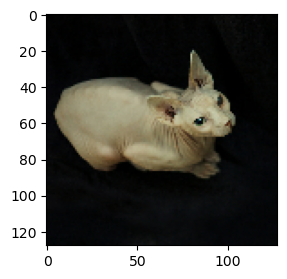

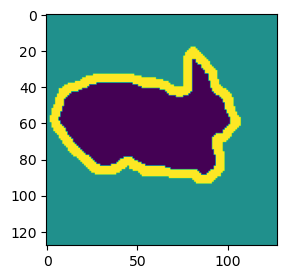

In [81]:
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.figure(figsize=(3, 3))
plt.imshow(np.array(mask).squeeze(-1))

In [83]:
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 5
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS,validation_data=test_dataset)

In [ ]:
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)

---